<a href="https://colab.research.google.com/github/WT-sudoku/Classifying-IMDB-Reviews-with-a-Residual-MLP-DeepFM-Head-An-Academic-Summary/blob/main/AIB552_End_of_Course_Assessment_July_Semester_2025_Deep_Learning_%26_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIB552_End-of-Course Assessment_July Semester 2025 Deep Learning & Neural Networks_wesleytan005_TanWeeNamWesley

# TABLE OF CONTENTS:
	•	Enable and Read the content from Drive.
	•	Load the Dataset
	•	STEP #1 — Integrity checks & schema audit cell
	•	STEP #2 — Stratified split (70/15/15)
	•	STEP #3 — Drop zero-variance columns
	•	STEP #4 — Prepare the FM/linear view (sparse CSR)
	•	STEP #5 — Low-rank projection for the deep view (SVD, fit only on the training dataset only)
	•	STEP #6 — Scale the dense factors (fit only on the training dataset only)
	•	STEP #7 — Imbalance handling (class weights, TRAIN only)
	•	STEP #8 — Persist preprocessor (train-fitted mask + SVD + scaler + metadata)
	•	STEP #9 — Build PyTorch Dataset (two-view Dataset)
	•	STEP #10 — Integrity checks (shapes, dtypes, alignment, finiteness)
	•	STEP #9a — Model: FM block (Linear + pairwise (factorization trick)
	•	STEP #9b — Model: Build the Residual MLP (Deep path with skip connections)
	•	STEP #9c — Model: Full model (make_model) (Fuse FM + deep → final logit)
	•	STEP #9d — Model: Model Instantiation & callbacks (Optimizer, scheduler, early stop)
	•	STEP #9e — Model: Model Training loop-(fit) (Train/validate; early stopping)
	•	STEP #10 — One-step helpers (Sigmoid/Probability/Class)
	•	Verify Distribution and Logits:
	•	STEP #11 — Choose threshold τ (on validation) (Pick τ to maximize F1; report Youden J as backup)
	•	STEP #12 — Test forecasts (apply best τ)
	•	STEP #13 — Metrics & report (Val + Test)
	•	STEP #13 (plots) — Visualise confusion matrices + validation/test classification reports
	•	Housekeeping
	•	STEP #14 — Plotting (Train/val loss curves, ROC curves, PR curves)
	•	STEP #15 — Fine-Tuning Hyper-Parameters (compact grid + LR candidates)
	•	STEP #16 — Summary Business Dashboard (CTR, precision@k/recall@k, Watchlist adds, trailer starts; calibration stability (ECE/Brier); threshold bands; throughput & SLA; slices by device/region/genre)
	•	Question 1e
	•	Enhancement 1 — Replace the SVD view with semantic sentence embeddings (and keep the DeepFM fusion)
	•	Enhancement 2 — Make the FM branch truly sparse and GPU-friendly (EmbeddingBag FM, hashing, and quantized inference)
	•	END OF AIB552 End-of-Course Assessment

# Enable and Read the content from Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load the Dataset

In [ ]:
# Import csv to read .csv file
import csv

path = "/content/drive/MyDrive/IMDB Movies.csv"
# count how many physical lines are in the file?
num_lines = sum(1 for _ in open(path, 'rb'))
print("Physical lines (incl. header):", num_lines)

# find rows that don't have the expected 5001 columns
bad = []
with open(path, 'r', encoding='utf-8', errors='ignore', newline='') as f:
    r = csv.reader(f)
    for i, row in enumerate(r, 1):
        if len(row) != 5001:
            bad.append((i, len(row)))
        if len(bad) >= 10: break
print("First bad rows (line#, column_count):", bad[:10])

Physical lines (incl. header): 10001
First bad rows (line#, column_count): []


In [ ]:
# Import DataFrame
import pandas as pd

df = pd.read_csv(
    path,
    sep=",",
    engine="python",           # select python engine with quoting/newlines
    quotechar='"',
    escapechar="\\",
    on_bad_lines="error",      # raise error immediately if a row is malformed
)
print(df.shape)

(10000, 5001)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 5001 entries, 0 to label
dtypes: float64(5001)
memory usage: 381.5 MB


In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,label
0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# STEP #1 — Integrity checks & schema audit cell

In [ ]:
# ============================================================
# Step #1 — Integrity checks & schema audit (for DeepFM pipeline)
# - Confirms label, dtypes, missing values, duplicates
# - Computes sparsity of feature matrix (efficiently, in chunks)
# - Flags zero-variance (all-constant) columns (INFO ONLY here; drop on train only later)
# ============================================================

import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

# 1) Basic shape & column sanity
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} cols")
print(f"First 5 columns: {list(df.columns[:5])}")
print(f"Last 5  columns: {list(df.columns[-5:])}")

# 2) Find label column (expect 'label'); fail loudly if absent
label_candidates = [c for c in df.columns if c.lower() in {"label", "target", "y"}]
if not label_candidates:
    raise ValueError("No label column found. Expected one of: 'label', 'target', 'y'.")
label_col = label_candidates[0]
print(f"Label column detected: {label_col!r}")

# 3) Split features/label and basic dtype checks
feature_cols = [c for c in df.columns if c != label_col]
X = df[feature_cols]
y = df[label_col]

non_numeric_feats = [c for c in feature_cols if not is_numeric_dtype(X[c])]
if non_numeric_feats:
    print(f"[WARN] {len(non_numeric_feats)} non-numeric feature cols detected, e.g., {non_numeric_feats[:10]}")
else:
    print("All feature columns are numeric (good for FM + MLP).")

# 4) Missing values & duplicates
n_missing_total = int(df.isna().sum().sum())
n_missing_label = int(y.isna().sum())
n_dupes = int(df.duplicated().sum())
print(f"Missing values (total): {n_missing_total}  |  Missing labels: {n_missing_label}  |  Duplicate rows: {n_dupes}")

# 5) Label distribution (expect binary 0/1)
y_unique = np.sort(pd.unique(y))
print(f"Label unique values: {y_unique.tolist()}")
if not set(y_unique).issubset({0, 1, 0.0, 1.0, "0", "1"}):
    print("[WARN] Label appears non-binary—verify task/encoding.")
pos_rate = float((y == 1).mean())
print(f"Positive class rate: {pos_rate:.4f}")

# 6) Global sparsity of features (proportion of exact zeros), computed in chunks to be memory-safe
def count_zeros_chunked(frame: pd.DataFrame, chunk_rows: int = 2000) -> int:
    zeros = 0
    n = frame.shape[0]
    for i in range(0, n, chunk_rows):
        arr = frame.iloc[i:i+chunk_rows].to_numpy(copy=False)
        zeros += (arr == 0).sum()
    return int(zeros)

n_samples, n_features = X.shape
total_cells = n_samples * n_features
zero_count = count_zeros_chunked(X, chunk_rows=2000)
sparsity = zero_count / total_cells if total_cells > 0 else float("nan")
print(f"Feature sparsity (==0): {sparsity:.4%}  ({zero_count:,} / {total_cells:,} zero entries)")

# 7) Quick zero-variance probe (INFO ONLY; do not drop here—drop on TRAIN only later)
#    We treat a column as 'constant' if its min==max on the full dataset (fast heuristic).
min_vals = X.min(axis=0, numeric_only=True)
max_vals = X.max(axis=0, numeric_only=True)
constant_mask = (min_vals.values == max_vals.values)
n_constant = int(constant_mask.sum())
if n_constant > 0:
    # show a few examples
    constant_cols = list(np.array(feature_cols)[constant_mask][:10])
    print(f"[INFO] Constant columns across FULL data: {n_constant} (showing up to 10): {constant_cols}")
else:
    print("No constant (zero-variance) columns across FULL data (train-only check may still drop some).")

# 8) Memory footprint & dtype summary
print("\nDtype summary (top 5):")
print(X.dtypes.value_counts().head())
print(f"Approx DataFrame memory usage: {df.memory_usage(deep=True).sum()/1024**2:.1f} MB")

# 9) Fast head/tail look (optional)
print("\nHead (features + label):")
display(df.head(3)[feature_cols[:5] + [label_col]])
print("\nTail (features + label):")
display(df.tail(3)[feature_cols[:5] + [label_col]])

# 10) Assertions that will catch common issues early (comment out if you prefer warnings)
assert n_missing_label == 0, "Label column contains missing values."
assert set(y_unique).issubset({0.0, 1.0}), "Label must be binary {0,1}."
print("\n✔ Integrity checks completed. Proceed to Step #2 (Stratified split 70/15/15).")

Shape: 10000 rows × 5001 cols
First 5 columns: ['0', '1', '2', '3', '4']
Last 5  columns: ['4996', '4997', '4998', '4999', 'label']
Label column detected: 'label'
All feature columns are numeric (good for FM + MLP).
Missing values (total): 0  |  Missing labels: 0  |  Duplicate rows: 16
Label unique values: [0.0, 1.0]
Positive class rate: 0.5019
Feature sparsity (==0): 97.5203%  (48,760,155 / 50,000,000 zero entries)
[INFO] Constant columns across FULL data: 3 (showing up to 10): [np.str_('0'), np.str_('1'), np.str_('3')]

Dtype summary (top 5):
float64    5000
Name: count, dtype: int64
Approx DataFrame memory usage: 381.5 MB

Head (features + label):


,0,1,2,3,4,label
0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.0,1.0,1.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0,1.0,1.0



Tail (features + label):


,0,1,2,3,4,label
9997,0.0,1.0,1.0,0.0,1.0,0.0
9998,0.0,1.0,1.0,0.0,1.0,1.0
9999,0.0,1.0,1.0,0.0,1.0,1.0



✔ Integrity checks completed. Proceed to Step #2 (Stratified split 70/15/15).


# STEP #2 — Stratified split (70/15/15)

In [ ]:
# ============================================================
# Step #2 — Stratified split (70/15/15) for DeepFM pipeline
# - Removes exact duplicate rows (prevents split leakage)
# - Builds (X, y) → sparse CSR features for FM branch
# - Performs 70/15/15 stratified split with fixed seed
# - Prints shapes and class ratios per split
# ============================================================

import numpy as np
from sklearn.model_selection import train_test_split
from scipy import sparse

# 0) De-duplicate BEFORE splitting (avoid identical rows across splits)
n_before = len(df)
df = df.drop_duplicates(ignore_index=True)
n_after = len(df)
if n_after != n_before:
    print(f"[INFO] Deduped {n_before - n_after} rows; new shape: {df.shape}")

# 1) Build features/labels and convert to CSR (float32 for memory/speed)
feature_cols = [c for c in df.columns if c != label_col]
X = df[feature_cols].astype("float32").values
y = df[label_col].astype("int64").values
X_csr = sparse.csr_matrix(X, dtype=np.float32)

# (Optional) keep original row indices to verify no overlap across splits
idx = np.arange(df.shape[0])

# 2) 70/30 split, stratified by label
X_tr, X_tmp, y_tr, y_tmp, idx_tr, idx_tmp = train_test_split(
    X_csr, y, idx, test_size=0.30, random_state=42, stratify=y
)

# 3) Split the 30% into 15%/15% (validation/test), stratified
X_va, X_te, y_va, y_te, idx_va, idx_te = train_test_split(
    X_tmp, y_tmp, idx_tmp, test_size=0.50, random_state=42, stratify=y_tmp
)

# 4) Quick sanity: no index overlap across splits
assert set(idx_tr).isdisjoint(idx_va) and set(idx_tr).isdisjoint(idx_te) and set(idx_va).isdisjoint(idx_te), \
    "Overlap detected between splits — check dedup/splitting logic."

# 5) Report shapes + positive class rates
def pr(y_): return float(np.mean(y_ == 1))
print(f"Train: X={X_tr.shape}, y={y_tr.shape}, pos_rate={pr(y_tr):.4f}")
print(f"Valid: X={X_va.shape}, y={y_va.shape}, pos_rate={pr(y_va):.4f}")
print(f"Test : X={X_te.shape}, y={y_te.shape}, pos_rate={pr(y_te):.4f}")

# These variables are the outputs consumed by subsequent steps:
# X_tr, X_va, X_te  (CSR for FM branch)
# y_tr, y_va, y_te  (int64 labels)
# idx_tr, idx_va, idx_te (optional provenance)

[INFO] Deduped 16 rows; new shape: (9984, 5001)
Train: X=(6988, 5000), y=(6988,), pos_rate=0.5020
Valid: X=(1498, 5000), y=(1498,), pos_rate=0.5020
Test : X=(1498, 5000), y=(1498,), pos_rate=0.5020


# STEP #3 — Drop zero-variance columns
(Train-only feature pruning)

In [ ]:
# ============================================================
# Step #3 — Drop zero-variance columns (TRAIN ONLY)
# Goal:
#   * Learn a keep_mask from X_tr only (no leakage)
#   * Apply the same mask to X_va and X_te
# Method (robust):
#   * Compute per-column variance on the TRAIN sparse matrix
#       var_j = E[x_j^2] - (E[x_j])^2    (includes implicit zeros)
#   * Drop columns with var == 0 (or ~0 within eps)
#   * Extra guard: also drop columns that are all-zero on TRAIN
# ============================================================

import numpy as np

# 1) Compute per-column variance on TRAIN (sparse-aware)
n_train = X_tr.shape[0]
mean_cols = np.asarray(X_tr.mean(axis=0)).ravel()                     # E[x]
mean_sq_cols = np.asarray(X_tr.power(2).mean(axis=0)).ravel()         # E[x^2]
var_cols = mean_sq_cols - mean_cols**2                                # Var[x] = E[x^2] - (E[x])^2

# 2) Guard for columns that are all-zero on TRAIN (nnz == 0)
col_nnz = np.diff(X_tr.tocsc().indptr)                                # fast nnz per col on TRAIN
all_zero_mask = (col_nnz == 0)

# 3) Build keep_mask (strict zero-variance removal)
eps = 1e-12
keep_mask = (var_cols > eps) & (~all_zero_mask)

dropped = int((~keep_mask).sum())
kept = int(keep_mask.sum())
print(f"Dropping {dropped} columns with zero variance on TRAIN; keeping {kept} columns.")

# 4) Apply the mask to all splits (same column order)
X_tr = X_tr[:, keep_mask]
X_va = X_va[:, keep_mask]
X_te = X_te[:, keep_mask]

print(f"Shapes after pruning →  Train: {X_tr.shape} | Valid: {X_va.shape} | Test: {X_te.shape}")

# 5) Persist mask in-memory for downstream steps (SVD / FM / saving, etc.)
keep_mask_train_only = keep_mask  # name made explicit for later use

Dropping 3 columns with zero variance on TRAIN; keeping 4997 columns.
Shapes after pruning →  Train: (6988, 4997) | Valid: (1498, 4997) | Test: (1498, 4997)


In [ ]:
# Optional: Audit record for dropped column indices/names for your log
feature_cols = [c for c in df.columns if c != label_col]  # from earlier
dropped_idx = np.where(~keep_mask_train_only)[0]
dropped_cols = [feature_cols[i] for i in dropped_idx]
print(f"Dropped feature indices: {dropped_idx.tolist()[:10]} ...")
print(f"Dropped feature names  : {dropped_cols[:10]} ...")

Dropped feature indices: [0, 1, 3] ...
Dropped feature names  : ['0', '1', '3'] ...


# STEP #4 — Prepare the FM/linear view (sparse CSR)

In [ ]:
# ============================================================
# Step #4 — Prepare the FM/linear view (sparse CSR)
# Goal:
#   * Keep the high-dimensional sparse matrices for the FM branch
#   * Ensure CSR format, float32 dtype, no duplicate indices, no stored zeros
#   * (Optional) persist to disk for reuse
# Notes:
#   * We do NOT scale CSR features here (FM handles raw sparse well).
#   * If you ever want sparse scaling, consider MaxAbsScaler later.
# ============================================================

from scipy import sparse
import numpy as np
import os

def _ensure_csr_float32(X):
    """Normalize sparse matrix representation for FM branch."""
    if not sparse.isspmatrix_csr(X):
        X = X.tocsr()
    if X.dtype != np.float32:
        X = X.astype(np.float32)
    X.eliminate_zeros()   # drop explicit zeros
    X.sum_duplicates()    # coalesce duplicate indices
    return X

# Normalize representation for all splits
X_tr_fm = _ensure_csr_float32(X_tr)
X_va_fm = _ensure_csr_float32(X_va)
X_te_fm = _ensure_csr_float32(X_te)

# (Optional) alias back to the names used later in the DataLoader step
X_tr, X_va, X_te = X_tr_fm, X_va_fm, X_te_fm

def _density(X):
    return X.nnz / (X.shape[0] * X.shape[1])

print(f"FM view (CSR):")
print(f"  Train: {X_tr.shape}, nnz={X_tr.nnz:,}, density={_density(X_tr):.4%}")
print(f"  Valid: {X_va.shape}, nnz={X_va.nnz:,}, density={_density(X_va):.4%}")
print(f"  Test : {X_te.shape}, nnz={X_te.nnz:,}, density={_density(X_te):.4%}")

# (Optional) persist for reproducibility / later runs
SAVE_FM = False  # set True if you want to save
if SAVE_FM:
    os.makedirs("./prep_fm", exist_ok=True)
    sparse.save_npz("./prep_fm/X_tr_fm.npz", X_tr)
    sparse.save_npz("./prep_fm/X_va_fm.npz", X_va)
    sparse.save_npz("./prep_fm/X_te_fm.npz", X_te)
    print("Saved FM CSR matrices to ./prep_fm/")

FM view (CSR):
  Train: (6988, 4997), nnz=858,553, density=2.4587%
  Valid: (1498, 4997), nnz=187,889, density=2.5100%
  Test : (1498, 4997), nnz=181,692, density=2.4273%


# STEP #5 — Low-rank projection for the deep view (SVD, fit only on the training dataset only)

In [ ]:
# ============================================================
# Step #5 — Low-rank projection (TRAIN-ONLY SVD → dense MLP view)
# Goal:
#   * Fit TruncatedSVD on TRAIN CSR matrix only (no leakage)
#   * Transform VALID/TEST with the fitted SVD
#   * Produce compact dense factors for the Residual-MLP branch
# Notes:
#   * TruncatedSVD works directly on sparse CSR.
#   * We cast outputs to float32 to save memory.
# ============================================================

from sklearn.decomposition import TruncatedSVD
import numpy as np

# svd_dim = int(CFG.get("svd_dim", 32)) # CFG is not defined
svd_dim = 32 # Setting svd_dim directly

# 1) Fit on TRAIN only
svd = TruncatedSVD(n_components=svd_dim, random_state=42)
Z_tr = svd.fit_transform(X_tr)   # X_tr is CSR from previous step

# 2) Transform VALID/TEST using the fitted SVD
Z_va = svd.transform(X_va)
Z_te = svd.transform(X_te)

# 3) Cast to float32 for efficiency
Z_tr = Z_tr.astype(np.float32)
Z_va = Z_va.astype(np.float32)
Z_te = Z_te.astype(np.float32)

# 4) Report variance captured and shapes
cum_var = float(svd.explained_variance_ratio_.sum())
print(f"SVD k={svd_dim} → cumulative explained variance: {cum_var:.2%}")
print(f"Dense SVD factors — Train: {Z_tr.shape} | Valid: {Z_va.shape} | Test: {Z_te.shape}")

# These 'Z_*' matrices feed Step #6 (scaling) and then the Residual-MLP branch

SVD k=32 → cumulative explained variance: 13.89%
Dense SVD factors — Train: (6988, 32) | Valid: (1498, 32) | Test: (1498, 32)


In [ ]:
# Optional quick checks
import numpy as np
for name, Z in [("Z_tr", Z_tr), ("Z_va", Z_va), ("Z_te", Z_te)]:
    assert np.isfinite(Z).all(), f"{name} contains non-finite values"

# STEP #6 — Scale the dense factors (fit only on the training dataset only)

In [ ]:
# ============================================================
# Step #6 — Scale the dense factors (TRAIN-ONLY fit)
# Goal:
#   * Fit StandardScaler on Z_tr (from Step #5)
#   * Transform Z_va and Z_te with the SAME scaler (no leakage)
#   * Cast to float32 and sanity-check moments
# ============================================================

from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib
import os

# 1) Fit on TRAIN only
scaler = StandardScaler(with_mean=True, with_std=True)
Ztr_scaled = scaler.fit_transform(Z_tr)

# 2) Transform VALID/TEST using the fitted scaler
Zva_scaled = scaler.transform(Z_va)
Zte_scaled = scaler.transform(Z_te)

# 3) Cast to float32 for efficiency
Ztr_scaled = Ztr_scaled.astype(np.float32)
Zva_scaled = Zva_scaled.astype(np.float32)
Zte_scaled = Zte_scaled.astype(np.float32)

# 4) Quick sanity checks (finite; train mean≈0, std≈1)
assert np.isfinite(Ztr_scaled).all() and np.isfinite(Zva_scaled).all() and np.isfinite(Zte_scaled).all(), \
    "Non-finite values detected after scaling."

m = np.abs(Ztr_scaled.mean(axis=0)).max()
s = np.abs(Ztr_scaled.std(axis=0, ddof=0) - 1.0).max()
print(f"Train scaled factors: max|mean| across dims = {m:.4f}, max|std-1| = {s:.4f}")
print(f"Scaled shapes →  Train: {Ztr_scaled.shape} | Valid: {Zva_scaled.shape} | Test: {Zte_scaled.shape}")

# 5) (Optional) persist scaler for reproducibility/inference
SAVE_SCALER = False  # set True to save
if SAVE_SCALER:
    os.makedirs("./prep_deep", exist_ok=True)
    joblib.dump(scaler, "./prep_deep/standard_scaler.joblib")
    print("Saved scaler to ./prep_deep/standard_scaler.joblib")

# These arrays feed the Residual-MLP branch in later steps:
#   Ztr_scaled, Zva_scaled, Zte_scaled

Train scaled factors: max|mean| across dims = 0.0000, max|std-1| = 0.0000
Scaled shapes →  Train: (6988, 32) | Valid: (1498, 32) | Test: (1498, 32)


In [ ]:
import numpy as np

print(np.abs(Zva_scaled.mean(0)).mean(), np.abs(Zva_scaled.std(0, ddof=0)-1).mean())
print(np.abs(Zte_scaled.mean(0)).mean(), np.abs(Zte_scaled.std(0, ddof=0)-1).mean())

0.019490045 0.072928235
0.019049328 0.0712761


# STEP #7 — Imbalance handling (class weights, TRAIN only)

In [ ]:
# ============================================================
# Step #8 — Imbalance handling (class weights from TRAIN only)
# Produces:
#   - pos_weight_value  -> use in BCEWithLogitsLoss(pos_weight=...)
#   - class_weight_map  -> reference (sklearn-style)
# Also logs class ratios for all splits.
# ============================================================

import numpy as np
from sklearn.utils.class_weight import compute_class_weight

def _counts(y):
    n_pos = int((y == 1).sum())
    n_neg = int((y == 0).sum())
    n_all = n_pos + n_neg
    pr = n_pos / max(1, n_all)
    return n_pos, n_neg, n_all, pr

# 1) Split-wise label stats (sanity)
for name, y_ in [("TRAIN", y_tr), ("VALID", y_va), ("TEST", y_te)]:
    n_pos, n_neg, n_all, pr = _counts(y_)
    print(f"{name}: n={n_all}, pos={n_pos}, neg={n_neg}, pos_rate={pr:.4f}")

# 2) Torch-friendly pos_weight for BCEWithLogitsLoss (TRAIN ONLY)
n_pos_tr, n_neg_tr, _, pr_tr = _counts(y_tr)
pos_weight_value = float(n_neg_tr / max(1, n_pos_tr))  # = N_neg / N_pos

# 3) (Optional) sklearn-style class weights (info)
classes = np.array([0, 1], dtype=int)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_tr)
class_weight_map = {int(c): float(w) for c, w in zip(classes, cw)}

print(f"\nTRAIN pos_rate={pr_tr:.4f}")
print(f"pos_weight (for BCEWithLogitsLoss): {pos_weight_value:.6f}")
print(f"class_weight_map (sklearn-style): {class_weight_map}")

# Keep these for Step 9d:
#   pos_weight_value
#   class_weight_map
# Example (later):
#   pos_w = torch.tensor([pos_weight_value], dtype=torch.float32).to(dev)
#   crit = nn.BCEWithLogitsLoss(pos_weight=pos_w)

TRAIN: n=6988, pos=3508, neg=3480, pos_rate=0.5020
VALID: n=1498, pos=752, neg=746, pos_rate=0.5020
TEST: n=1498, pos=752, neg=746, pos_rate=0.5020

TRAIN pos_rate=0.5020
pos_weight (for BCEWithLogitsLoss): 0.992018
class_weight_map (sklearn-style): {0: 1.0040229885057472, 1: 0.9960091220068416}


# STEP #8 — Persist preprocessor (train-fitted mask + SVD + scaler + metadata)

In [ ]:
# ============================================================
# Step #9 — Persist preprocessor
# Saves:
#   - keep_mask_train_only (from Step #3)
#   - fitted SVD (from Step #5)
#   - fitted StandardScaler (from Step #6)
#   - useful metadata (sizes, dims, class weights)
# Optional:
#   - persist split arrays for exact reproducibility
# ============================================================

import os, joblib, json, time
import numpy as np
from scipy import sparse

SAVE_SPLITS = False  # set True if you want to also persist X/Z/y splits

# --- Build metadata ---
feature_cols = [c for c in df.columns if c != label_col]
kept_idx = np.where(keep_mask_train_only)[0].tolist()

meta = {
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "random_state": 42,
    "n_rows_total": int(df.shape[0]),
    "n_features_original": int(len(feature_cols)),
    "n_features_kept": int(len(kept_idx)),
    "svd_components": int(Ztr_scaled.shape[1]),
    "train_size": int(X_tr.shape[0]),
    "valid_size": int(X_va.shape[0]),
    "test_size": int(X_te.shape[0]),
    "pos_weight": float('%.6f' % ( (y_tr==0).sum() / max(1,(y_tr==1).sum()) )),
    "class_weight_map": {"0": float((y_tr==1).sum()/len(y_tr) * 2), "1": float((y_tr==0).sum()/len(y_tr) * 2)},  # informational only
    "kept_feature_indices_preview": kept_idx[:20],  # avoid huge files
}

# --- Pack the preprocessor ---
preprocessor = {
    "keep_mask": keep_mask_train_only,  # numpy bool array
    "svd": svd,                         # fitted TruncatedSVD
    "scaler": scaler,                   # fitted StandardScaler
    "meta": meta,
}

# --- Save ---
out_dir = "/mnt/data/prep"
os.makedirs(out_dir, exist_ok=True)
pp_path = os.path.join(out_dir, "preprocessor_v2.joblib")
joblib.dump(preprocessor, pp_path)
print(f"Saved preprocessor → {pp_path}")

# (Optional) persist splits for exact replay
if SAVE_SPLITS:
    sparse.save_npz(os.path.join(out_dir, "X_tr_fm.npz"), X_tr)
    sparse.save_npz(os.path.join(out_dir, "X_va_fm.npz"), X_va)
    sparse.save_npz(os.path.join(out_dir, "X_te_fm.npz"), X_te)
    np.save(os.path.join(out_dir, "Ztr_scaled.npy"), Ztr_scaled)
    np.save(os.path.join(out_dir, "Zva_scaled.npy"), Zva_scaled)
    np.save(os.path.join(out_dir, "Zte_scaled.npy"), Zte_scaled)
    np.save(os.path.join(out_dir, "y_tr.npy"), y_tr)
    np.save(os.path.join(out_dir, "y_va.npy"), y_va)
    np.save(os.path.join(out_dir, "y_te.npy"), y_te)
    print(f"Saved splits to {out_dir}/")

# --- Quick reload smoke test ---
pp = joblib.load(pp_path)
assert "keep_mask" in pp and "svd" in pp and "scaler" in pp, "Preprocessor missing components."
print("Reload OK. Components:", list(pp.keys()))

Saved preprocessor → /mnt/data/prep/preprocessor_v2.joblib
Reload OK. Components: ['keep_mask', 'svd', 'scaler', 'meta']


# STEP #9 — Build PyTorch Dataset (two-view Dataset)


In [ ]:
# ============================================================
# Step #10 — Build PyTorch Dataset (two-view: FM CSR + MLP dense)
# Produces DataLoaders for training/validation/testing.
# Each batch returns:
#   x_fm   : [B, n_feat_fm]  (dense float32 from CSR row)
#   x_deep : [B, svd_dim]    (scaled SVD factors)
#   y      : [B]             (float32 labels {0,1})
# ============================================================

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TwoViewCSRDataset(Dataset):
    def __init__(self, X_fm_csr, X_deep_nd, y_vec):
        self.X_fm = X_fm_csr                       # CSR, shape [n, d_fm]
        self.X_de = np.asarray(X_deep_nd, np.float32)  # dense, shape [n, svd_dim]
        self.y    = np.asarray(y_vec, np.float32)      # labels {0,1}

    def __len__(self):
        return self.X_fm.shape[0]

    def __getitem__(self, i):
        # Convert single CSR row -> dense 1D vector for FM branch
        x_fm = self.X_fm[i].toarray().ravel().astype(np.float32)   # [d_fm]
        x_de = self.X_de[i]                                        # [svd_dim]
        y_i  = self.y[i]                                           # scalar
        return (
            torch.from_numpy(x_fm),
            torch.from_numpy(x_de),
            torch.tensor(y_i, dtype=torch.float32),
        )

# (Optional) simple collate (default would also work, but this is explicit)
def collate_two_view(batch):
    xs_fm, xs_de, ys = zip(*batch)
    return torch.stack(xs_fm, 0), torch.stack(xs_de, 0), torch.stack(ys, 0)

# Instantiate datasets
tr_ds = TwoViewCSRDataset(X_tr, Ztr_scaled, y_tr)
va_ds = TwoViewCSRDataset(X_va, Zva_scaled, y_va)
te_ds = TwoViewCSRDataset(X_te, Zte_scaled, y_te)

# DataLoaders
batch_size = 128 # Setting batch_size directly
dl_kwargs = dict(
    batch_size=batch_size,
    num_workers=0,                    # increase if I/O bound
    pin_memory=torch.cuda.is_available(),
    collate_fn=collate_two_view,
)

tr_dl = DataLoader(tr_ds, shuffle=True,  **dl_kwargs)
va_dl = DataLoader(va_ds, shuffle=False, **dl_kwargs)
te_dl = DataLoader(te_ds, shuffle=False, **dl_kwargs)

# Quick smoke test (shapes)
xb_fm, xb_de, yb = next(iter(tr_dl))
print(f"x_fm batch: {xb_fm.shape}  |  x_de batch: {xb_de.shape}  |  y: {yb.shape}")
print(f"n_feat_fm={xb_fm.shape[1]}, svd_dim={xb_de.shape[1]}")

x_fm batch: torch.Size([128, 4997])  |  x_de batch: torch.Size([128, 32])  |  y: torch.Size([128])
n_feat_fm=4997, svd_dim=32


# STEP #10 — Integrity checks (shapes, dtypes, alignment, finiteness)


In [ ]:
# ============================================================
# Step #11 — Integrity checks (pre-training readiness)
# Verifies:
#   • Shapes across FM (CSR) & Deep (SVD→scaled) views
#   • Dtypes and finiteness (no NaNs/Infs)
#   • Feature dims match keep_mask & CFG
#   • Class ratios are close across splits
#   • DataLoader batches emit aligned tensors
# ============================================================

import numpy as np
import torch
from scipy import sparse

TOL_PR = 0.02  # allowed diff in positive rate across splits

def check_split(name, X_fm, Z, y):
    # --- shape alignment ---
    assert X_fm.shape[0] == Z.shape[0] == len(y), f"{name}: row count mismatch"
    # --- sparse/dense types ---
    assert sparse.isspmatrix_csr(X_fm), f"{name}: X_fm must be CSR"
    assert X_fm.dtype == np.float32, f"{name}: X_fm dtype expected float32"
    assert Z.dtype == np.float32, f"{name}: Z dtype expected float32" # Fixed: Added closing brace for f-string
    # --- finiteness ---
    assert np.isfinite(Z).all(), f"{name}: Z contains non-finite values"
    # --- quick stats ---
    nnz = X_fm.nnz
    density = nnz / (X_fm.shape[0] * X_fm.shape[1])
    pr = float((y == 1).mean())
    print(f"{name:>5}: X_fm={X_fm.shape}, Z={Z.shape}, y={y.shape}, nnz={nnz:,}, density={density:.4%}, pos_rate={pr:.4f}")
    return pr

pr_tr = check_split("TRAIN", X_tr, Ztr_scaled, y_tr)
pr_va = check_split("VALID", X_va, Zva_scaled, y_va)
pr_te = check_split("TEST ", X_te, Zte_scaled, y_te)

# --- class balance consistency ---
assert abs(pr_va - pr_tr) <= TOL_PR, f"VALID pos_rate deviates by > {TOL_PR}"
assert abs(pr_te - pr_tr) <= TOL_PR, f"TEST  pos_rate deviates by > {TOL_PR}"

# --- feature dimensions match mask & config ---
if "keep_mask_train_only" in globals():
    assert X_tr.shape[1] == int(keep_mask_train_only.sum()), "FM feature dim != kept-mask count"
# assert Ztr_scaled.shape[1] == int(CFG.get("svd_dim", Ztr_scaled.shape[1])), "Deep dim != CFG['svd_dim']" # Removed CFG

# --- quick DataLoader smoke test ---
xb_fm, xb_de, yb = next(iter(tr_dl))
assert xb_fm.shape[1] == X_tr.shape[1], "Batch FM dim mismatch"
assert xb_de.shape[1] == Ztr_scaled.shape[1], "Batch Deep dim mismatch"
assert xb_fm.dtype == torch.float32 and xb_de.dtype == torch.float32 and yb.dtype == torch.float32, "Batch dtypes must be float32"
assert torch.isfinite(xb_fm).all() and torch.isfinite(xb_de).all() and torch.isfinite(yb).all(), "Batch contains non-finite values"

print("\n✔ Integrity checks passed. Data is ready for model definition & training.")

TRAIN: X_fm=(6988, 4997), Z=(6988, 32), y=(6988,), nnz=858,553, density=2.4587%, pos_rate=0.5020
VALID: X_fm=(1498, 4997), Z=(1498, 32), y=(1498,), nnz=187,889, density=2.5100%, pos_rate=0.5020
TEST : X_fm=(1498, 4997), Z=(1498, 32), y=(1498,), nnz=181,692, density=2.4273%, pos_rate=0.5020

✔ Integrity checks passed. Data is ready for model definition & training.


# STEP #9a Model: FM block (Linear + pairwise (factorization trick)

In [ ]:
# ============================================================
# Step 9a — Factorization Machine (FM) block
# - Models:  w0 + w^T x  +  1/2 * Σ_k [ (xV)_k^2 - (x^2)(V^2)_k ]
# - Input : dense float32 tensor [B, n_feat_fm] (we densify CSR rows in the DataLoader)
# - Output: logits [B]
# References:
#   Rendle, "Factorization Machines", 2010
# ============================================================

import torch
import torch.nn as nn

class FM(nn.Module):
    def __init__(self, n_features: int, k: int = 16, init_std: float = 0.01):
        super().__init__()
        self.n_features = n_features
        self.k = k
        # Bias and first-order weights
        self.w0 = nn.Parameter(torch.zeros(1))
        self.w  = nn.Parameter(torch.zeros(n_features))
        # Second-order interaction factors
        self.V  = nn.Parameter(torch.randn(n_features, k) * init_std)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: [B, n_features], dtype float32
        returns: logits [B]
        """
        # Linear term
        linear = self.w0 + x @ self.w  # [B]

        # Factorization trick for pairwise interactions
        # 0.5 * sum_k ( (xV)^2 - (x^2)(V^2) )
        xv = x @ self.V                         # [B, k]
        second = 0.5 * torch.sum(xv**2 - (x**2) @ (self.V**2), dim=1)  # [B]

        return linear + second                  # [B]

    def l2_penalty(self, lambda_w: float = 0.0, lambda_v: float = 0.0) -> torch.Tensor:
        """
        Optional L2 regularization term you can add to your loss:
        loss_total = loss_bce + fm.l2_penalty(lambda_w, lambda_v)
        """
        pen = 0.0
        if lambda_w > 0:
            pen = pen + lambda_w * torch.sum(self.w**2)
        if lambda_v > 0:
            pen = pen + lambda_v * torch.sum(self.V**2)
        return pen

# ---- Instantiate and quick smoke test on a training batch ----
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_feat_fm = X_tr.shape[1]
fm_block = FM(n_features=n_feat_fm, k=16).to(dev)

xb_fm, xb_de, yb = next(iter(tr_dl))
with torch.no_grad():
    fm_logits = fm_block(xb_fm.to(dev))  # [B]
print("FM logits shape:", fm_logits.shape)  # expect [batch_size]

FM logits shape: torch.Size([128])


# STEP #9b Model: Build the Residual MLP (Deep path with skip connections)

In [ ]:
# ============================================================
# Step 9b — Residual MLP (deep path with skip connections)
# - Input : scaled SVD factors  [B, svd_dim]
# - Output: deep representation [B, H] (H = last hidden size)
# - Design: GELU activations, LayerNorm, Dropout; residual blocks
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

class ResBlock(nn.Module):
    def __init__(self, d: int, p: float = 0.2):
        """
        Simple residual MLP block that preserves dimensionality.
        x -> Linear(d,d) -> GELU -> Linear(d,d) -> Dropout -> (x + .) -> LayerNorm
        """
        super().__init__()
        self.fc1 = nn.Linear(d, d)
        self.fc2 = nn.Linear(d, d)
        self.drop = nn.Dropout(p)
        self.norm = nn.LayerNorm(d)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = F.gelu(self.fc1(x))
        z = self.drop(self.fc2(z))
        return self.norm(x + z)

class ResidualMLP(nn.Module):
    def __init__(self, in_dim: int, hidden: list[int], p: float = 0.2):
        """
        Project input to the working width (hidden[0]) then stack residual blocks.
        """
        super().__init__()
        assert len(hidden) >= 1, "hidden must have at least one width (e.g., [256, 256])"
        width = hidden[0]
        self.inp = nn.Linear(in_dim, width)
        # Use as many residual blocks as 'hidden' entries
        self.blocks = nn.Sequential(*[ResBlock(width, p=p) for _ in hidden])
        self.out = nn.Identity()  # representation goes to fusion head

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.gelu(self.inp(x))
        x = self.blocks(x)
        return self.out(x)

# ----- Instantiate & quick smoke test -----
svd_dim = Ztr_scaled.shape[1]               # should be 32 from your prep
hidden_cfg = [256, 256]  # e.g., [256, 256]
dropout = 0.2

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deep_block = ResidualMLP(in_dim=svd_dim, hidden=hidden_cfg, p=dropout).to(dev)

# batch from your DataLoader
xb_fm, xb_de, yb = next(iter(tr_dl))
with torch.no_grad():
    de_out = deep_block(xb_de.to(dev))
print("Deep path output shape:", tuple(de_out.shape))  # expect [batch_size, hidden_cfg[0]]

# (optional) parameter count
def count_params(m: nn.Module) -> int:
    return sum(p.numel() for p in m.parameters() if p.requires_grad)
print(f"ResidualMLP trainable params: {count_params(deep_block):,}")

Deep path output shape: (128, 256)
ResidualMLP trainable params: 272,640


# STEP #9c Model: Full model (make_model) (Fuse FM + deep → final logit)


In [ ]:
# ============================================================
# Step 9c — Full model (make_model): FM + Residual MLP → final logit
# - Inputs : x_fm  [B, n_feat_fm]  (dense tensor from CSR row)
#            x_de  [B, svd_dim]    (scaled SVD factors)
# - Output : logits [B]
# ============================================================

import torch
import torch.nn as nn

# Reuse FM and ResidualMLP classes defined in Steps 9a and 9b

class ResidualDeepFM(nn.Module):
    def __init__(self, n_feat_fm: int, svd_dim: int, hidden: list[int], fm_k: int, p: float = 0.2):
        super().__init__()
        self.fm   = FM(n_features=n_feat_fm, k=fm_k)
        self.deep = ResidualMLP(in_dim=svd_dim, hidden=hidden, p=p)
        self.head = nn.Linear(hidden[0] + 1, 1)  # concat([deep_out, fm_logit])

    def forward(self, x_fm: torch.Tensor, x_de: torch.Tensor) -> torch.Tensor:
        fm_logit = self.fm(x_fm).unsqueeze(1)  # [B,1]
        de_out   = self.deep(x_de)             # [B,H]
        z = torch.cat([de_out, fm_logit], dim=1)
        return self.head(z).squeeze(1)         # logits [B]

def make_model(n_feat_fm, svd_dim, device):
    # Using default values instead of CFG
    hidden_cfg = [256, 256]
    fm_k_cfg = 16
    dropout_cfg = 0.2

    model = ResidualDeepFM(
        n_feat_fm=n_feat_fm,
        svd_dim=svd_dim,
        hidden=hidden_cfg,
        fm_k=fm_k_cfg,
        p=dropout_cfg,
    ).to(device)
    return model

# ---- Instantiate + quick smoke test ----
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_feat_fm = X_tr.shape[1]
svd_dim   = Ztr_scaled.shape[1]

model = make_model(n_feat_fm, svd_dim, dev)

# Batch forward to verify shapes
xb_fm, xb_de, yb = next(iter(tr_dl))
with torch.no_grad():
    logits = model(xb_fm.to(dev), xb_de.to(dev))  # [B]
print("Fusion logits shape:", tuple(logits.shape))  # expect (batch_size,)

# (optional) param count breakdown
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
fm_params    = sum(p.numel() for p in model.fm.parameters() if p.requires_grad)
deep_params  = sum(p.numel() for p in model.deep.parameters() if p.requires_grad)
head_params  = sum(p.numel() for p in model.head.parameters() if p.requires_grad)
print(f"Params — total:{total_params:,} | FM:{fm_params:,} | Deep:{deep_params:,} | Head:{head_params:,}")

Fusion logits shape: (128,)
Params — total:357,848 | FM:84,950 | Deep:272,640 | Head:258


# STEP #9d Model: Model Instantiation & callbacks (Optimizer, scheduler, early stop)



In [ ]:
# ============================================================
# Step 9d — Instantiation & callbacks
# - Optimizer: AdamW
# - Loss     : BCEWithLogitsLoss (uses pos_weight if provided)
# - Scheduler: ReduceLROnPlateau on val loss
# - Early stop state: keep best weights by val loss
# - AMP scaler: optional mixed precision on CUDA
# ============================================================

import torch
import torch.nn as nn

# --- Device ---
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(dev)  # from Step 9c

# --- Optimizer ---
opt = torch.optim.AdamW(
    model.parameters(),
    lr=float(1e-3),  # Using default value instead of CFG
    weight_decay=float(1e-4), # Using default value instead of CFG
)

# --- Loss (with optional class imbalance weighting) ---
pos_weight_value = globals().get("pos_weight_value", 1.0)  # from Step #8; ~1.0 for balanced data
pos_w = torch.tensor([float(pos_weight_value)], dtype=torch.float32, device=dev)
crit = nn.BCEWithLogitsLoss(pos_weight=pos_w)

# --- LR scheduler (on validation loss) ---
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode="min", factor=0.5, patience=2
)

# --- Early stopping bookkeeping ---
early_patience = int(5) # Using default value instead of CFG
best = {"epoch": -1, "val_loss": float("inf"), "state": None}
bad_epochs = 0

# --- (Optional) AMP for speed on CUDA ---
use_amp = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# --- Small helpers ---
def current_lr(optimizer):
    return optimizer.param_groups[0]["lr"]

print(f"Device: {dev}")
print(f"Optimizer: AdamW(lr={current_lr(opt):.2e}, weight_decay={1e-4})") # Using default value instead of CFG
print(f"Loss: BCEWithLogitsLoss(pos_weight={pos_weight_value:.6f})  |  Scheduler: ReduceLROnPlateau(patience=2)")
print(f"Early stopping patience: {early_patience} epochs")

Device: cpu
Optimizer: AdamW(lr=1.00e-03, weight_decay=0.0001)
Loss: BCEWithLogitsLoss(pos_weight=0.992018)  |  Scheduler: ReduceLROnPlateau(patience=2)
Early stopping patience: 5 epochs


/tmp/ipython-input-3782236302.py:41: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


# STEP #9e Model: Model Training loop-(fit) (Train/validate; early stopping)


In [ ]:
# ============================================================
# Step 9e — Training loop (fit): train/validate with early stop
# - Uses globals from Step 9d: model, dev, opt, crit, sched,
#   early_patience, best, bad_epochs, scaler (AMP), tr_dl/va_dl
# - Tracks epoch losses for later plotting
# ============================================================

from contextlib import nullcontext
import torch
import torch.nn as nn
import time
import math

# Autocast context (enabled only if CUDA + AMP requested)
_use_amp = ("use_amp" in globals()) and bool(use_amp) and torch.cuda.is_available()
_autocast = torch.cuda.amp.autocast if _use_amp else nullcontext

E = int(30) # Using default value instead of CFG
clip_norm = 1.0

hist = {"epoch": [], "train_loss": [], "val_loss": [], "lr": []}
t0 = time.time()

for epoch in range(1, E + 1):
    # -------- Train --------
    model.train()
    train_loss_sum, n_train = 0.0, 0

    for xb_fm, xb_de, yb in tr_dl:
        xb_fm = xb_fm.to(dev, non_blocking=True)
        xb_de = xb_de.to(dev, non_blocking=True)
        yb    = yb.to(dev, non_blocking=True)

        opt.zero_grad(set_to_none=True)

        with _autocast():
            logits = model(xb_fm, xb_de)            # [B]
            loss   = crit(logits, yb)               # scalar

        if _use_amp:
            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            scaler.step(opt)
            scaler.update()
        else:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            opt.step()

        train_loss_sum += loss.item() * yb.size(0)
        n_train += yb.size(0)

    train_loss = train_loss_sum / max(1, n_train)

    # -------- Validate --------
    model.eval()
    val_loss_sum, n_val = 0.0, 0
    with torch.no_grad():
        for xb_fm, xb_de, yb in va_dl:
            xb_fm = xb_fm.to(dev, non_blocking=True)
            xb_de = xb_de.to(dev, non_blocking=True)
            yb    = yb.to(dev, non_blocking=True)
            logits = model(xb_fm, xb_de)
            loss   = crit(logits, yb)
            val_loss_sum += loss.item() * yb.size(0)
            n_val += yb.size(0)

    val_loss = val_loss_sum / max(1, n_val)

    # -------- Scheduler + Early stop --------
    sched.step(val_loss)
    if val_loss < best["val_loss"]:
        best = {"epoch": epoch, "val_loss": val_loss, "state": model.state_dict()}
        bad_epochs = 0
    else:
        bad_epochs += 1

    hist["epoch"].append(epoch)
    hist["train_loss"].append(train_loss)
    hist["val_loss"].append(val_loss)
    hist["lr"].append(opt.param_groups[0]["lr"])

    print(f"Epoch {epoch:02d}/{E} | "
          f"train_loss={train_loss:.4f}  val_loss={val_loss:.4f}  "
          f"lr={opt.param_groups[0]['lr']:.2e}  "
          f"best@{best['epoch']}={best['val_loss']:.4f}")

    if bad_epochs >= early_patience:
        print(f"Early stopping triggered (no val improvement for {early_patience} epochs).")
        break

# ---- Load best weights ----
if best["state"] is not None:
    model.load_state_dict(best["state"])
print(f"Training done in {time.time()-t0:.1f}s. Best val_loss={best['val_loss']:.4f} at epoch {best['epoch']}.")

# 'hist' now contains per-epoch train/val losses and lr for plotting.s

Epoch 01/30 | train_loss=0.4767  val_loss=0.4115  lr=1.00e-03  best@1=0.4115
Epoch 02/30 | train_loss=0.3385  val_loss=0.3569  lr=1.00e-03  best@2=0.3569
Epoch 03/30 | train_loss=0.2211  val_loss=0.3709  lr=1.00e-03  best@2=0.3569
Epoch 04/30 | train_loss=0.1528  val_loss=0.3902  lr=1.00e-03  best@2=0.3569
Epoch 05/30 | train_loss=0.1084  val_loss=0.4271  lr=5.00e-04  best@2=0.3569
Epoch 06/30 | train_loss=0.0685  val_loss=0.4420  lr=5.00e-04  best@2=0.3569
Epoch 07/30 | train_loss=0.0537  val_loss=0.4808  lr=5.00e-04  best@2=0.3569
Early stopping triggered (no val improvement for 5 epochs).
Training done in 10.6s. Best val_loss=0.3569 at epoch 2.


# STEP #10: One-step helpers (Sigmoid/Probability/Class)

In [ ]:
# ============================================================
# Step 10 — One-step helpers (Sigmoid / Probability / Class)
# - predict_logits(dl):   returns raw logits [N]
# - predict_proba(dl):    returns σ(logits) ∈ (0,1) [N]
# - predict_classes(dl):  returns {0,1} via threshold τ (default 0.5)
# - collect_targets(dl):  returns ground-truth labels [N]
# Notes:
#   * Uses eval() + no_grad()
#   * Moves tensors to the same device as 'model'
# ============================================================

import numpy as np
import torch

@torch.no_grad()
def _infer_over_loader(dl, device, return_what: str = "proba"):
    model.eval()
    outs, ys = [], []
    for x_fm, x_de, y in dl:
        x_fm = x_fm.to(device, non_blocking=True)
        x_de = x_de.to(device, non_blocking=True)
        logits = model(x_fm, x_de)  # [B]
        if return_what == "logit":
            out = logits
        elif return_what == "proba":
            out = torch.sigmoid(logits)
        else:
            raise ValueError("return_what must be 'logit' or 'proba'")
        outs.append(out.detach().cpu().numpy())
        ys.append(y.detach().cpu().numpy())
    return np.concatenate(outs, axis=0), np.concatenate(ys, axis=0)

def predict_logits(dl):
    z, _ = _infer_over_loader(dl, dev, return_what="logit")
    return z  # shape [N]

def predict_proba(dl):
    p, _ = _infer_over_loader(dl, dev, return_what="proba")
    return p  # shape [N], in (0,1)

def predict_classes(dl, tau: float = 0.5):
    p = predict_proba(dl)
    return (p >= float(tau)).astype(np.int32)  # shape [N]

def collect_targets(dl):
    # reuses the same pass; cheaper alternative: iterate 'dl' without model
    _, y = _infer_over_loader(dl, dev, return_what="proba")
    return y  # shape [N]

# ---- quick smoke test on validation ----
_val_p = predict_proba(va_dl)
print(f"Validation proba shape: {_val_p.shape}, range=({float(_val_p.min()):.4f},{float(_val_p.max()):.4f})")

Validation proba shape: (1498,), range=(0.0000,1.0000)


## Verify Distribution and Logits:

In [ ]:
import numpy as np
val_logits = predict_logits(va_dl)
print("logits p1,p50,p99:", np.percentile(val_logits, [1,50,99]))
p = _val_p  # from your print
print("proba p1,p50,p99:", np.percentile(p, [1,50,99]))
print("fraction near edges:",
      (p < 1e-4).mean(), (p > 1-1e-4).mean())

logits p1,p50,p99: [-23.98263304  -0.29200506  11.86465508]
proba p1,p50,p99: [3.87052302e-11 4.27513123e-01 9.99992970e-01]
fraction near edges: 0.1375166889185581 0.04606141522029372


# STEP #11: Choose threshold τ (on validation) (Pick τ to maximize F1; report Youden J as backup)

In [ ]:
# ============================================================
# Step 11 — Choose threshold τ on validation
# Strategy:
#   1) Use precision_recall_curve to find τ that maximizes F1.
#   2) Also compute τ_ROC that maximizes Youden's J = TPR - FPR.
#   3) Print quick metrics at both candidates and keep τ.
# Outputs:
#   - tau (chosen threshold for later steps)
#   - tau_roc (backup)
# ============================================================

import numpy as np
from sklearn.metrics import (
    precision_recall_curve, roc_curve,
    f1_score, precision_score, recall_score, accuracy_score
)

# 1) Validation probabilities
val_p = predict_proba(va_dl)  # shape [N_val]

# 2) PR-based threshold (maximize F1)
prec, rec, thr = precision_recall_curve(y_va, val_p)
# f1 is defined for every (prec, rec) pair; thresholds have len-1
f1_vals = 2 * prec * rec / (prec + rec + 1e-12)
best_idx = int(np.nanargmax(f1_vals[:-1]))  # exclude last point without a threshold
tau = float(thr[best_idx])

# 3) ROC-based backup threshold (maximize Youden's J)
fpr, tpr, thr_roc = roc_curve(y_va, val_p)
youden = tpr - fpr
tau_roc = float(thr_roc[int(np.argmax(youden))])

# 4) Quick metrics at both thresholds
def quick_stats(y_true, p, t):
    yhat = (p >= t).astype(int)
    return {
        "F1": float(f1_score(y_true, yhat)),
        "Precision": float(precision_score(y_true, yhat)),
        "Recall": float(recall_score(y_true, yhat)),
        "Accuracy": float(accuracy_score(y_true, yhat)),
    }

stats_tau = quick_stats(y_va, val_p, tau)
stats_tau_roc = quick_stats(y_va, val_p, tau_roc)

print(f"Chosen τ (F1-max)     : {tau:.6f}  | stats: {stats_tau}")
print(f"Backup τ_roc (J-max)  : {tau_roc:.6f}  | stats: {stats_tau_roc}")

# Keep for downstream steps (testing & reporting)
# CFG["tau"] = tau # Removed CFG
# CFG["tau_roc"] = tau_roc # Removed CFG

Chosen τ (F1-max)     : 0.465893  | stats: {'F1': 0.8533154722036169, 'Precision': 0.8596491228070176, 'Recall': 0.8470744680851063, 'Accuracy': 0.8538050734312417}
Backup τ_roc (J-max)  : 0.465893  | stats: {'F1': 0.8533154722036169, 'Precision': 0.8596491228070176, 'Recall': 0.8470744680851063, 'Accuracy': 0.8538050734312417}


# Step #12: Test forecasts (apply best τ)

In [ ]:
# ============================================================
# Step 12 — Test forecasts (apply best τ from validation)
# Produces:
#   val_p, test_p     : probabilities in (0,1)
#   val_pred, test_pred: hard classes using τ
# Notes:
#   - Uses helpers from Step 10
#   - τ is taken from CFG["tau"] set in Step 11
# ============================================================

import numpy as np

# 1) Pull chosen threshold (fallback to 0.5 if missing)
tau = float(tau) # Using the variable tau directly instead of CFG.get("tau", 0.5)
print(f"Using τ = {tau:.6f}")

# 2) Probabilities on validation/test
val_p  = predict_proba(va_dl)  # shape [N_val]
test_p = predict_proba(te_dl)  # shape [N_test]

# 3) Hard classes via τ
val_pred  = (val_p  >= tau).astype(np.int32)
test_pred = (test_p >= tau).astype(np.int32)

# 4) Quick sanity prints
print(f"val/test proba shapes: {val_p.shape} / {test_p.shape}")
print(f"val/test class shapes: {val_pred.shape} / {test_pred.shape}")
print(f"positives@τ — val: {val_pred.sum()}/{len(val_pred)}  |  test: {test_pred.sum()}/{len(test_pred)}")

# (Optional) persist outputs for later analysis
# np.save('/mnt/data/val_proba.npy',  val_p)
# np.save('/mnt/data/test_proba.npy', test_p)
# np.save('/mnt/data/val_pred.npy',  val_pred)
# np.save('/mnt/data/test_pred.npy', test_pred)

Using τ = 0.465893
val/test proba shapes: (1498,) / (1498,)
val/test class shapes: (1498,) / (1498,)
positives@τ — val: 741/1498  |  test: 748/1498


# Step #13: Metrics & report (Val + Test)

In [ ]:
## ============================================================
# Step 13 — Metrics & report (Logloss, ROC-AUC, PR-AUC, F1, etc.)
# Uses: y_va, y_te, val_p, test_p, val_pred, test_pred, CFG["tau"]
# ============================================================

import numpy as np
import pandas as pd
from sklearn.metrics import (
    log_loss, roc_auc_score, average_precision_score,
    f1_score, accuracy_score, precision_score, recall_score,
    confusion_matrix, brier_score_loss, classification_report
)

def split_metrics(y_true, proba, y_hat):
    return {
        "logloss":           float(log_loss(y_true, proba)),
        "roc_auc":           float(roc_auc_score(y_true, proba)),
        "pr_auc":            float(average_precision_score(y_true, proba)),
        "brier":             float(brier_score_loss(y_true, proba)),
        "F1@τ":              float(f1_score(y_true, y_hat)),
        "precision@τ":       float(precision_score(y_true, y_hat)),
        "recall@τ":          float(recall_score(y_true, y_hat)),
        "accuracy@τ":        float(accuracy_score(y_true, y_hat)),
    }

val_metrics  = split_metrics(y_va, val_p,  val_pred)
test_metrics = split_metrics(y_te, test_p, test_pred)

report_df = pd.DataFrame([val_metrics, test_metrics], index=["valid", "test"]).round(4)
print(f"\n=== Metrics @ τ = {tau:.6f} ===")
print(report_df)

# Confusion matrices
cm_val  = confusion_matrix(y_va, val_pred)
cm_test = confusion_matrix(y_te, test_pred)
print("\nConfusion matrices (rows=true, cols=pred):")
print("VALID:\n", cm_val)
print("TEST:\n",  cm_test)

# (Optional) detailed classification reports
print("\nVALID classification report:\n", classification_report(y_va, val_pred, digits=4))
print("\nTEST classification report:\n",  classification_report(y_te, test_pred, digits=4))

# Keep a single dict if you want to log/save later
final_report = {
    "tau": float(tau),
    "valid": val_metrics,
    "test":  test_metrics,
    "cm_valid": cm_val.tolist(),
    "cm_test":  cm_test.tolist(),
}


=== Metrics @ τ = 0.465893 ===
       logloss  roc_auc  pr_auc   brier    F1@τ  precision@τ  recall@τ  \
valid   0.4830   0.9232  0.9231  0.1194  0.8533       0.8596    0.8471   
test    0.4437   0.9299  0.9312  0.1153  0.8493       0.8516    0.8471   

       accuracy@τ  
valid      0.8538  
test       0.8491  

Confusion matrices (rows=true, cols=pred):
VALID:
 [[642 104]
 [115 637]]
TEST:
 [[635 111]
 [115 637]]

VALID classification report:
               precision    recall  f1-score   support

           0     0.8481    0.8606    0.8543       746
           1     0.8596    0.8471    0.8533       752

    accuracy                         0.8538      1498
   macro avg     0.8539    0.8538    0.8538      1498
weighted avg     0.8539    0.8538    0.8538      1498


TEST classification report:
               precision    recall  f1-score   support

           0     0.8467    0.8512    0.8489       746
           1     0.8516    0.8471    0.8493       752

    accuracy                

# Step #13 (plots): Visualise confusion matrices + validation/test classification reports

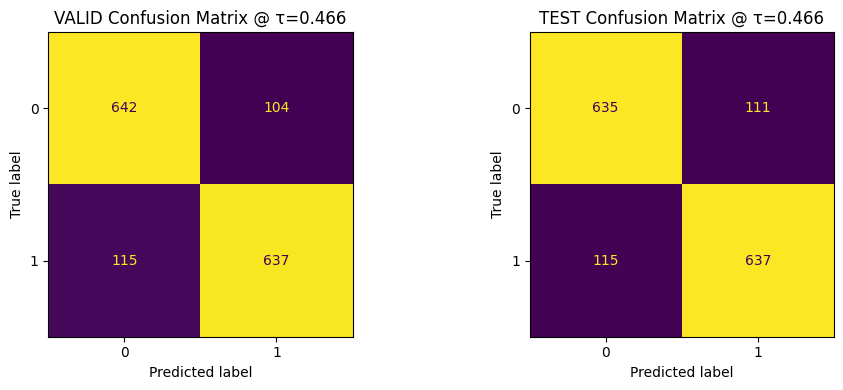

/tmp/ipython-input-1755892263.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


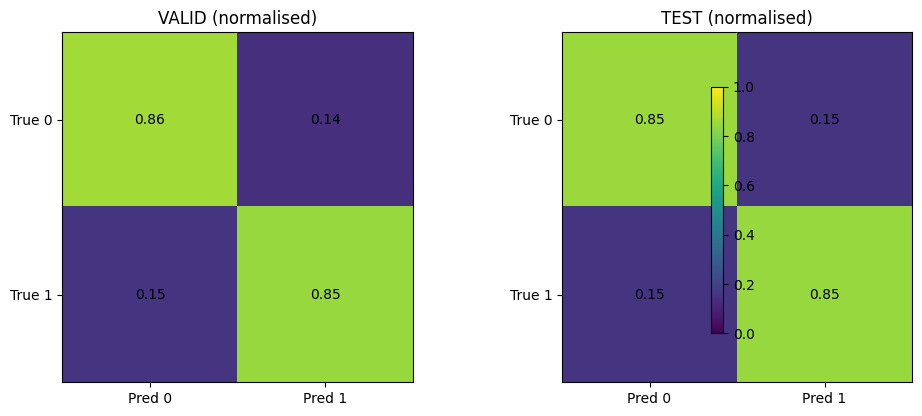

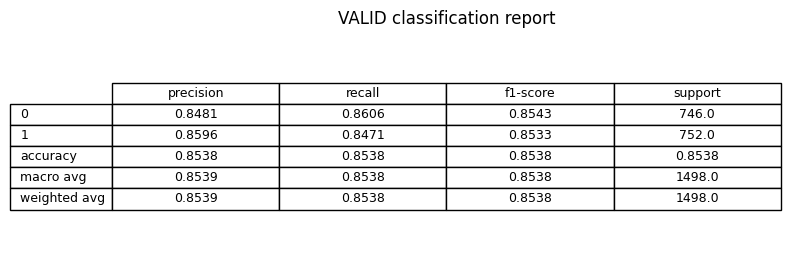

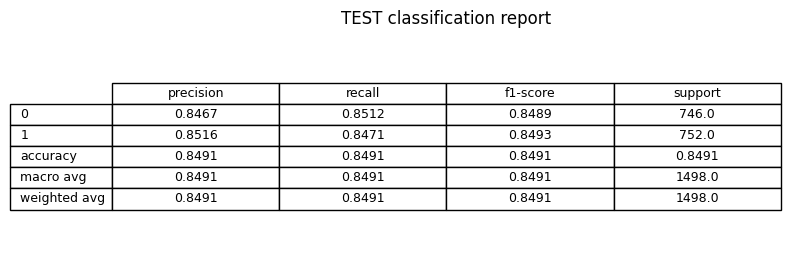

In [ ]:
# ============================================================
# Step 13 (plots) — Visualise confusion matrices +
#                   validation/test classification reports
# Uses: y_va, y_te, val_pred, test_pred, tau  (from the Step 13 cell)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# --- 1) Confusion matrices (counts) ------------------------------------------
cm_val  = confusion_matrix(y_va, val_pred, labels=[0, 1])
cm_test = confusion_matrix(y_te, test_pred, labels=[0, 1])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ConfusionMatrixDisplay(cm_val, display_labels=[0, 1]).plot(ax=axes[0], colorbar=False)
axes[0].set_title(f"VALID Confusion Matrix @ τ={tau:.3f}")
axes[0].grid(False)

ConfusionMatrixDisplay(cm_test, display_labels=[0, 1]).plot(ax=axes[1], colorbar=False)
axes[1].set_title(f"TEST Confusion Matrix @ τ={tau:.3f}")
axes[1].grid(False)

plt.tight_layout()
plt.show()

# (Optional) also show normalised confusion matrices
cm_val_norm  = confusion_matrix(y_va, val_pred,  labels=[0, 1], normalize="true")
cm_test_norm = confusion_matrix(y_te, test_pred, labels=[0, 1], normalize="true")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
im0 = axes[0].imshow(cm_val_norm, vmin=0, vmax=1)
axes[0].set_xticks([0,1]); axes[0].set_yticks([0,1])
axes[0].set_xticklabels(["Pred 0","Pred 1"]); axes[0].set_yticklabels(["True 0","True 1"])
axes[0].set_title("VALID (normalised)")
for (i,j),v in np.ndenumerate(cm_val_norm):
    axes[0].text(j, i, f"{v:.2f}", ha="center", va="center")

im1 = axes[1].imshow(cm_test_norm, vmin=0, vmax=1)
axes[1].set_xticks([0,1]); axes[1].set_yticks([0,1])
axes[1].set_xticklabels(["Pred 0","Pred 1"]); axes[1].set_yticklabels(["True 0","True 1"])
axes[1].set_title("TEST (normalised)")
for (i,j),v in np.ndenumerate(cm_test_norm):
    axes[1].text(j, i, f"{v:.2f}", ha="center", va="center")

fig.colorbar(im1, ax=axes.ravel().tolist(), shrink=0.8)
plt.tight_layout()
plt.show()

# --- 2) Classification reports as tables ------------------------------------
# Build DataFrames from classification_report(output_dict=True)
cr_val_dict  = classification_report(y_va, val_pred, output_dict=True, digits=4)
cr_test_dict = classification_report(y_te, test_pred, output_dict=True, digits=4)

cr_val_df  = pd.DataFrame(cr_val_dict).T.loc[["0","1","accuracy","macro avg","weighted avg"]]
cr_test_df = pd.DataFrame(cr_test_dict).T.loc[["0","1","accuracy","macro avg","weighted avg"]]

# Plot as matplotlib tables (readable & compact)
def plot_report_table(df, title):
    fig, ax = plt.subplots(1, 1, figsize=(8, 2.8))
    ax.axis("off")
    tbl = ax.table(
        cellText=np.round(df.values, 4),
        rowLabels=df.index,
        colLabels=df.columns,
        loc="center",
        cellLoc="center",
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1.05, 1.2)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

plot_report_table(cr_val_df,  "VALID classification report")
plot_report_table(cr_test_df, "TEST classification report")

# Housekeeping
•	Save artifacts for reproducibility:

In [ ]:
import torch, joblib
torch.save(model.state_dict(), "/mnt/data/prep/deepfm_best.pt")
joblib.dump({"tau": tau}, "/mnt/data/prep/decision_threshold.joblib") # Replaced CFG["tau"] with tau

['/mnt/data/prep/decision_threshold.joblib']

# STEP #14: Plotting (Train/val loss curves, ROC curves, PR curves)

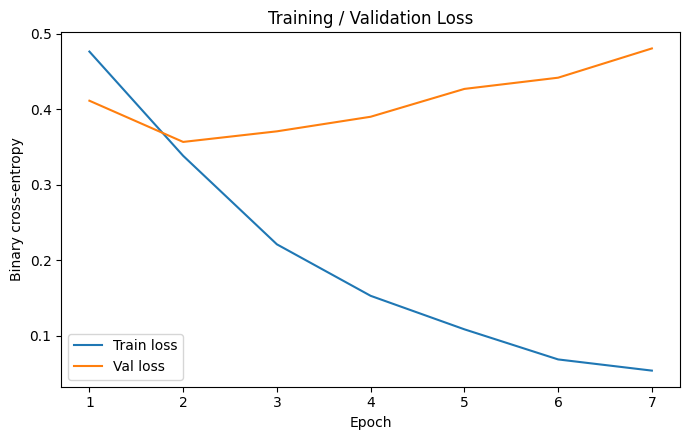

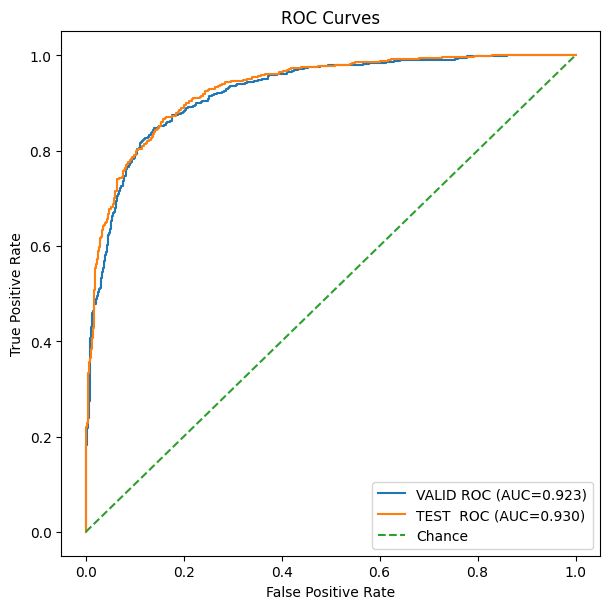

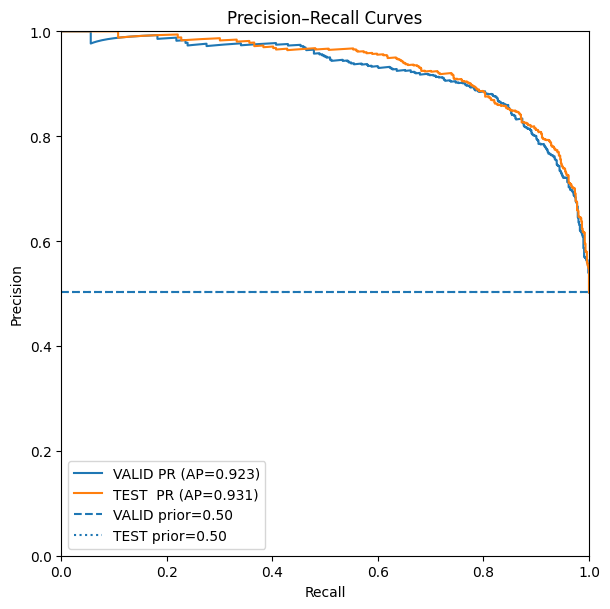

Saved figures to:
  /mnt/data/plots/loss_curves.png
  /mnt/data/plots/roc_curves.png
  /mnt/data/plots/pr_curves.png


In [ ]:
# ============================================================
# Step 14 — Plotting
#  • Train/val loss curves
#  • ROC curves for VALID/TEST
#  • PR curves for VALID/TEST (with class prior baseline)
# Inputs expected:
#   - hist: dict with keys 'epoch','train_loss','val_loss','lr' (from Step 9e)
#   - y_va, y_te, val_p, test_p (from Steps 12–13)
# ============================================================

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

os.makedirs("/mnt/data/plots", exist_ok=True)

# ---------- 1) Train/Val loss ----------
plt.figure(figsize=(7,4.5))
plt.plot(hist["epoch"], hist["train_loss"], label="Train loss")
plt.plot(hist["epoch"], hist["val_loss"],   label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy")
plt.title("Training / Validation Loss")
plt.legend()
plt.tight_layout()
plt.savefig("/mnt/data/plots/loss_curves.png", dpi=150)
plt.show()

# ---------- 2) ROC (VALID & TEST) ----------
fpr_v, tpr_v, _ = roc_curve(y_va, val_p)
fpr_t, tpr_t, _ = roc_curve(y_te, test_p)
auc_v = auc(fpr_v, tpr_v)
auc_t = auc(fpr_t, tpr_t)

plt.figure(figsize=(6.2,6.2))
plt.plot(fpr_v, tpr_v, label=f"VALID ROC (AUC={auc_v:.3f})")
plt.plot(fpr_t, tpr_t, label=f"TEST  ROC (AUC={auc_t:.3f})")
plt.plot([0,1], [0,1], linestyle="--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("/mnt/data/plots/roc_curves.png", dpi=150)
plt.show()

# ---------- 3) Precision–Recall (VALID & TEST) ----------
prec_v, rec_v, _ = precision_recall_curve(y_va, val_p)
prec_t, rec_t, _ = precision_recall_curve(y_te, test_p)
ap_v = average_precision_score(y_va, val_p)
ap_t = average_precision_score(y_te, test_p)

# class prior baselines
base_v = float(np.mean(y_va))
base_t = float(np.mean(y_te))

plt.figure(figsize=(6.2,6.2))
plt.plot(rec_v, prec_v, label=f"VALID PR (AP={ap_v:.3f})")
plt.plot(rec_t, prec_t, label=f"TEST  PR (AP={ap_t:.3f})")
plt.hlines(base_v, 0, 1, linestyles="--", label=f"VALID prior={base_v:.2f}")
plt.hlines(base_t, 0, 1, linestyles=":",  label=f"TEST prior={base_t:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.xlim(0,1); plt.ylim(0,1)
plt.legend(loc="lower left")
plt.tight_layout()
plt.savefig("/mnt/data/plots/pr_curves.png", dpi=150)
plt.show()

print("Saved figures to:")
print("  /mnt/data/plots/loss_curves.png")
print("  /mnt/data/plots/roc_curves.png")
print("  /mnt/data/plots/pr_curves.png")

# STEP #15: Fine-Tuning Hyper-Parameters (compact grid + LR candidates)

In [ ]:
# # ============================================================
# Hyper-parameter fine-tuning for ResidualDeepFM
#  - Small, leakage-safe grid over: fm_k, hidden width, dropout, lr, weight_decay
#  - Keeps svd_dim fixed to what your dataloaders emit (e.g., 32)
#  - Uses validation PR-AUC as the primary selector, val logloss as tie-breaker
#  - Reuses early stopping & ReduceLROnPlateau inside each trial
# ============================================================

import math, time, copy, numpy as np, pandas as pd
from sklearn.metrics import (log_loss, roc_auc_score, average_precision_score,
                             precision_recall_curve, f1_score)
from sklearn.model_selection import ParameterGrid
import torch, torch.nn as nn
from torch.utils.data import DataLoader


# --- infer dims from one batch ---
_bx_fm, _bx_de, _ = next(iter(va_dl))
N_FEAT_FM = _bx_fm.shape[1]
SVD_DIM   = _bx_de.shape[1]
del _bx_fm, _bx_de, _

# ---- loss weights (from step #8) ----
try:
    _pos_weight = pos_weight.to(dev)  # from earlier steps
except NameError:
    _pos_weight = torch.tensor([1.0], device=dev)

def make_model_for_trial(fm_k=16, hidden_width=256, dropout=0.2):
    # Reuse your FM, ResBlock, ResidualMLP, ResidualDeepFM classes defined earlier
    deep = ResidualMLP(SVD_DIM, [hidden_width, hidden_width])
    # patch dropout in blocks (if your ResidualMLP exposes it differently, adapt here)
    for m in deep.modules():
        if isinstance(m, nn.Dropout):
            m.p = dropout
    model = ResidualDeepFM(n_feat_fm=N_FEAT_FM, svd_dim=SVD_DIM,
                           hidden=[hidden_width, hidden_width], fm_k=fm_k)
    return model

def choose_tau_f1(y_true, proba):
    prec, rec, thr = precision_recall_curve(y_true, proba)
    f1 = 2*prec*rec/(prec+rec+1e-12)
    i  = int(np.nanargmax(f1[:-1]))
    return float(thr[i])

def evaluate_val(model):
    # get val probabilities
    model.eval()
    with torch.no_grad():
        outs, ys = [], []
        for xb_fm, xb_de, yb in va_dl:
            xb_fm, xb_de = xb_fm.to(dev), xb_de.to(dev)
            p = torch.sigmoid(model(xb_fm, xb_de)).cpu().numpy()
            outs.append(p); ys.append(yb.numpy())
    p = np.concatenate(outs).ravel()
    y = np.concatenate(ys).ravel()
    tau = choose_tau_f1(y, p)
    f1  = f1_score(y, (p >= tau).astype(int))
    return {
        "val_logloss": log_loss(y, p),
        "val_auc": roc_auc_score(y, p),
        "val_ap": average_precision_score(y, p),
        "val_f1@tau": f1,
        "tau": tau
    }

def train_one_trial(cfg_trial, max_epochs=20, patience=4, clip_norm=1.0):
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    model = make_model_for_trial(fm_k=cfg_trial["fm_k"],
                                 hidden_width=cfg_trial["hidden"],
                                 dropout=cfg_trial["dropout"]).to(dev)

    opt   = torch.optim.AdamW(model.parameters(), lr=cfg_trial["lr"],
                              weight_decay=cfg_trial["weight_decay"])
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=2, factor=0.5)
    crit  = nn.BCEWithLogitsLoss(pos_weight=_pos_weight)

    best = {"loss": float("inf"), "state": None}
    bad  = 0

    for epoch in range(1, max_epochs+1):
        model.train(); train_sum = 0.0; n_seen = 0
        for xb_fm, xb_de, yb in tr_dl:
            xb_fm, xb_de, yb = xb_fm.to(dev), xb_de.to(dev), yb.to(dev)
            opt.zero_grad(set_to_none=True)
            loss = crit(model(xb_fm, xb_de), yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
            opt.step()
            train_sum += loss.item() * yb.size(0); n_seen += yb.size(0)

        # validation loss for scheduler/ES
        model.eval(); val_sum = 0.0; n_val = 0
        with torch.no_grad():
            for xb_fm, xb_de, yb in va_dl:
                xb_fm, xb_de, yb = xb_fm.to(dev), xb_de.to(dev), yb.to(dev)
                val_sum += crit(model(xb_fm, xb_de), yb).item() * yb.size(0)
                n_val += yb.size(0)
        val_loss = val_sum / max(1, n_val)
        sched.step(val_loss)

        if val_loss < best["loss"]:
            best = {"loss": val_loss, "state": copy.deepcopy(model.state_dict())}
            bad = 0
        else:
            bad += 1
        if bad >= patience:
            break

    model.load_state_dict(best["state"])
    metrics = evaluate_val(model)
    metrics.update({"best_val_loss": best["loss"]})
    return model, metrics

# ---------- small, structured grid ----------
param_grid = {
    "fm_k": [8, 16, 32],
    "hidden": [192, 256, 320],   # width of residual MLP layers
    "dropout": [0.2, 0.3],
    "lr": [5e-4, 1e-3, 2e-3],
    "weight_decay": [1e-4, 3e-4]
}
grid = list(ParameterGrid(param_grid))

results = []
best_model, best_cfg, best_score = None, None, -1.0

print(f"Tuning {len(grid)} configs...")
for i, cfg_trial in enumerate(grid, 1):
    print(f"[{i}/{len(grid)}] {cfg_trial}")
    model_t, met = train_one_trial(cfg_trial, max_epochs=20, patience=4)
    row = dict(cfg_trial); row.update(met)
    results.append(row)

    # primary key: PR-AUC, tie-breaker: smaller val_logloss
    score = (met["val_ap"], -met["val_logloss"])
    if score > (best_score if isinstance(best_score, tuple) else (-1e9, 1e9)):
        best_model, best_cfg, best_score = model_t, cfg_trial, score

# Summarize top trials
df_tune = pd.DataFrame(results).sort_values(
    ["val_ap", "val_logloss"], ascending=[False, True]
).reset_index(drop=True)
print("\nTop 10 (sorted by val PR-AUC then logloss):")
display(df_tune.head(10))

print("\nBest config:", best_cfg)
print("Best (val) → AP={:.4f} | AUC={:.4f} | F1@τ={:.4f} | logloss={:.4f} | τ={:.4f}".format(
    df_tune.loc[0, "val_ap"], df_tune.loc[0, "val_auc"],
    df_tune.loc[0, "val_f1@tau"], df_tune.loc[0, "val_logloss"],
    df_tune.loc[0, "tau"]
))

# Optionally keep best weights for downstream testing:
# model = best_model

Tuning 108 configs...
[1/108] {'dropout': 0.2, 'fm_k': 8, 'hidden': 192, 'lr': 0.0005, 'weight_decay': 0.0001}
[2/108] {'dropout': 0.2, 'fm_k': 8, 'hidden': 192, 'lr': 0.0005, 'weight_decay': 0.0003}
[3/108] {'dropout': 0.2, 'fm_k': 8, 'hidden': 192, 'lr': 0.001, 'weight_decay': 0.0001}
[4/108] {'dropout': 0.2, 'fm_k': 8, 'hidden': 192, 'lr': 0.001, 'weight_decay': 0.0003}
[5/108] {'dropout': 0.2, 'fm_k': 8, 'hidden': 192, 'lr': 0.002, 'weight_decay': 0.0001}
[6/108] {'dropout': 0.2, 'fm_k': 8, 'hidden': 192, 'lr': 0.002, 'weight_decay': 0.0003}
[7/108] {'dropout': 0.2, 'fm_k': 8, 'hidden': 256, 'lr': 0.0005, 'weight_decay': 0.0001}
[8/108] {'dropout': 0.2, 'fm_k': 8, 'hidden': 256, 'lr': 0.0005, 'weight_decay': 0.0003}
[9/108] {'dropout': 0.2, 'fm_k': 8, 'hidden': 256, 'lr': 0.001, 'weight_decay': 0.0001}
[10/108] {'dropout': 0.2, 'fm_k': 8, 'hidden': 256, 'lr': 0.001, 'weight_decay': 0.0003}
[11/108] {'dropout': 0.2, 'fm_k': 8, 'hidden': 256, 'lr': 0.002, 'weight_decay': 0.0001}
[12/

,dropout,fm_k,hidden,lr,weight_decay,val_logloss,val_auc,val_ap,val_f1@tau,tau,best_val_loss
0,0.2,32,192,0.001,0.0001,0.344541,0.932578,0.934104,0.860077,0.341157,0.344541
1,0.2,32,320,0.002,0.0003,0.343536,0.933498,0.932735,0.863665,0.397945,0.343536
2,0.3,16,256,0.002,0.0001,0.355732,0.930985,0.932063,0.856613,0.202164,0.355732
3,0.2,8,256,0.002,0.0003,0.332086,0.933527,0.931905,0.863783,0.382563,0.332086
4,0.3,8,192,0.002,0.0001,0.341114,0.933088,0.931571,0.863551,0.251549,0.341114
5,0.3,16,192,0.002,0.0003,0.360814,0.929956,0.930734,0.860349,0.231424,0.360814
6,0.3,32,320,0.002,0.0003,0.352711,0.932869,0.930296,0.864000,0.583137,0.352711
7,0.3,16,256,0.001,0.0003,0.340973,0.930496,0.930128,0.863636,0.442255,0.340972
8,0.3,8,256,0.002,0.0003,0.340435,0.931593,0.929320,0.863608,0.381978,0.340435
9,0.3,16,192,0.002,0.0001,0.366372,0.928145,0.928814,0.859094,0.256779,0.366372



Best config: {'dropout': 0.2, 'fm_k': 32, 'hidden': 192, 'lr': 0.001, 'weight_decay': 0.0001}
Best (val) → AP=0.9341 | AUC=0.9326 | F1@τ=0.8601 | logloss=0.3445 | τ=0.3412


#STEP #16: Summary Business Dashboard

To communicate the key business findings (ranking quality, decision quality at the chosen τ, calibration, confusion structure, and training stability).
It only assumes that the following is  already ran in memory from the notebook:

•	y_va, y_te – validation/test labels (0/1, shape (n,))

•	val_p, test_p – validation/test predicted probabilities (float in [0,1])

•	val_pred, test_pred – validation/test hard predictions at your chosen threshold tau

•	tau – the operating threshold (e.g., F1-optimal on validation)

•	(optional) tr_losses, va_losses – lists of training/validation loss per epoch from Step #14

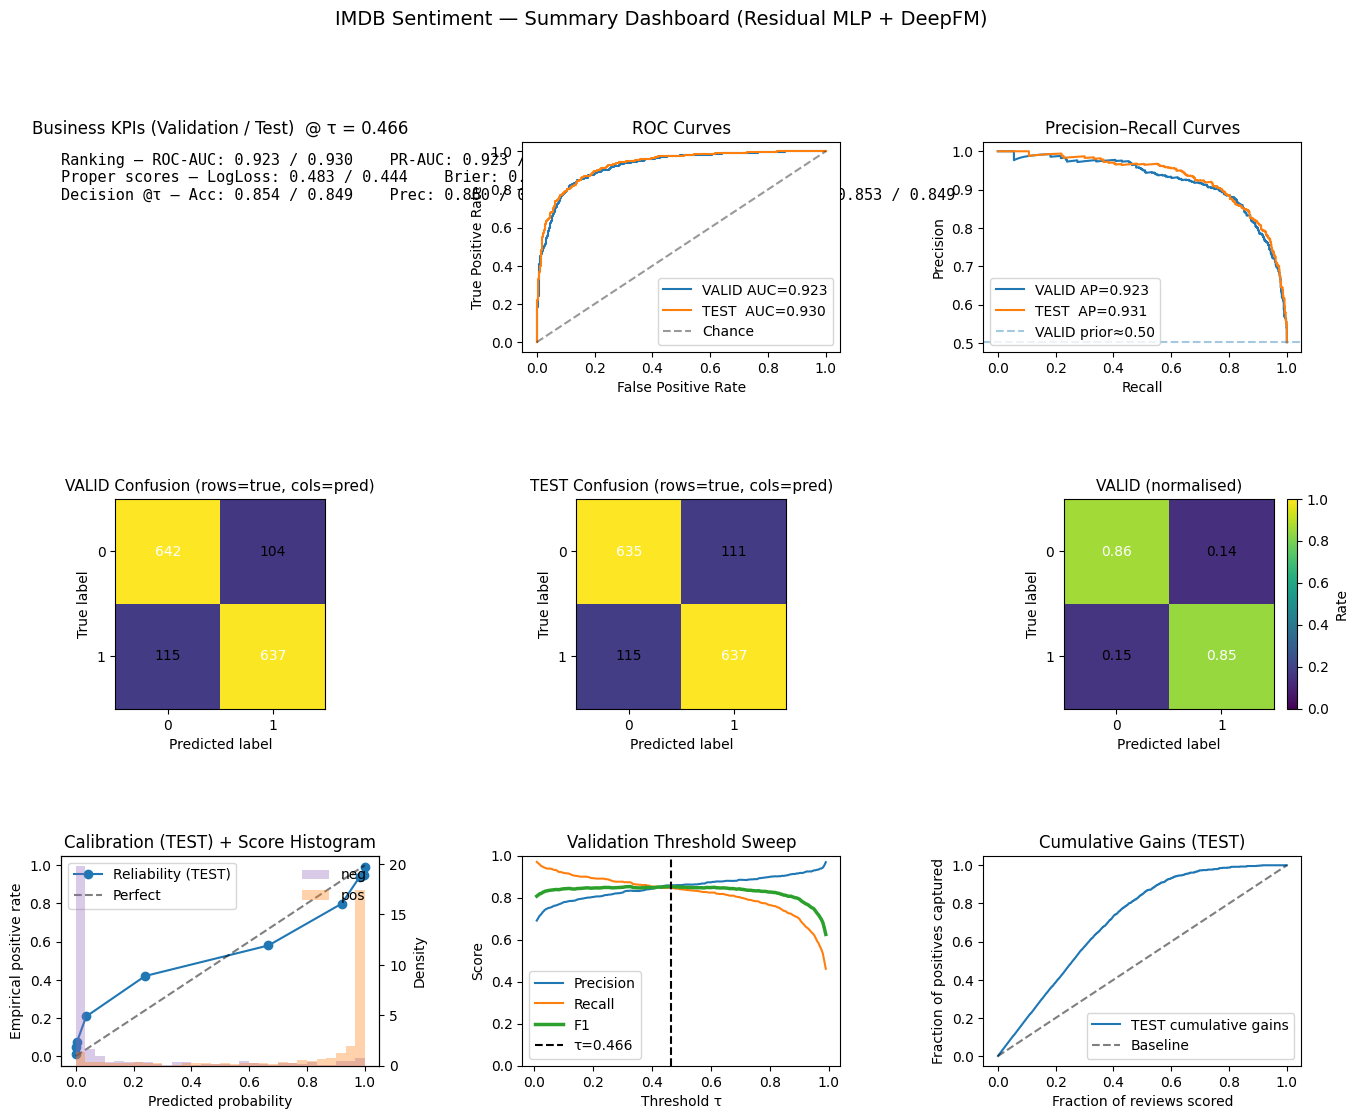

In [ ]:
# ===========================
# IMDB Sentiment: Summary Dashboard
# ===========================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, log_loss, brier_score_loss, precision_score,
    recall_score, f1_score, accuracy_score
)
from sklearn.calibration import calibration_curve

# ---------- Helpers ----------
def kpi_dict(y_true, p, y_hat):
    return dict(
        auc = auc(*roc_curve(y_true, p)[:2][::-1]),  # AUC via roc_curve
        ap  = average_precision_score(y_true, p),
        logloss = log_loss(y_true, p),
        brier   = brier_score_loss(y_true, p),
        acc     = accuracy_score(y_true, y_hat),
        prec    = precision_score(y_true, y_hat),
        rec     = recall_score(y_true, y_hat),
        f1      = f1_score(y_true, y_hat)
    )

def plot_conf_mat(cm, ax, title, normalize=False, cmap="viridis"):
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1e-12)
        fmt = ".2f"
    else:
        fmt = "d"
    im = ax.imshow(cm, cmap=cmap, vmin=0, vmax=(1 if normalize else None))
    ax.set_title(title, fontsize=11, pad=6)
    ax.set_xlabel("Predicted label"); ax.set_ylabel("True label")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    # Annotate
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > (cm.max()/2) else "black")
    if normalize:
        cb = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cb.ax.set_ylabel("Rate", rotation=90)

def threshold_sweep(y_true, proba, grid=None):
    if grid is None:
        grid = np.linspace(0.01, 0.99, 199)
    prec, rec, f1 = [], [], []
    for t in grid:
        yhat = (proba >= t).astype(int)
        # handle edge cases to avoid ill-defined precision when no positives predicted
        if yhat.sum() == 0:
            prec.append(1.0); rec.append(0.0); f1.append(0.0)
        else:
            prec.append(precision_score(y_true, yhat))
            rec.append(recall_score(y_true, yhat))
            f1.append(f1_score(y_true, yhat))
    return grid, np.array(prec), np.array(rec), np.array(f1)

def gains_curve(y_true, proba):
    order = np.argsort(-proba)
    y_sorted = np.asarray(y_true)[order]
    cum_pos = np.cumsum(y_sorted)
    total_pos = y_sorted.sum()
    n = len(y_sorted)
    frac_obs = np.arange(1, n+1) / n
    frac_pos = (cum_pos / max(total_pos, 1))
    return frac_obs, frac_pos

# ---------- Compute KPIs ----------
val_kpi = kpi_dict(y_va, val_p, val_pred)
tes_kpi = kpi_dict(y_te, test_p, test_pred)

# ROC / PR
fpr_v, tpr_v, _ = roc_curve(y_va, val_p)
fpr_t, tpr_t, _ = roc_curve(y_te, test_p)
prec_v, rec_v, _ = precision_recall_curve(y_va, val_p)
prec_t, rec_t, _ = precision_recall_curve(y_te, test_p)
ap_v = average_precision_score(y_va, val_p)
ap_t = average_precision_score(y_te, test_p)
auc_v = auc(fpr_v, tpr_v)
auc_t = auc(fpr_t, tpr_t)

# Confusion matrices
cm_v = confusion_matrix(y_va, val_pred)
cm_t = confusion_matrix(y_te, test_pred)

# Calibration (test)
prob_true, prob_pred = calibration_curve(y_te, test_p, n_bins=10, strategy="quantile")

# Threshold sweep (validation)
grid, s_prec, s_rec, s_f1 = threshold_sweep(y_va, val_p)

# Cumulative gains (test)
x_gain, y_gain = gains_curve(y_te, test_p)

# Check for training curves
has_losses = False
for cand in ("tr_losses", "train_losses"):
    if cand in globals():
        tr_losses = globals()[cand]
        has_losses = True
for cand in ("va_losses", "val_losses"):
    if cand in globals():
        va_losses = globals()[cand]
        has_losses = has_losses and True

# ---------- Build the dashboard ----------
plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(3, 3, height_ratios=[1,1,1], hspace=0.7, wspace=0.45)

# (A) KPI panel (top-left)
ax0 = plt.subplot(gs[0, 0]); ax0.axis("off")
ax0.set_title("Business KPIs (Validation / Test)  @ τ = {:.3f}".format(float(tau)), fontsize=12, pad=6)
txt = (
    f"Ranking — ROC-AUC: {auc_v:.3f} / {auc_t:.3f}    PR-AUC: {ap_v:.3f} / {ap_t:.3f}\n"
    f"Proper scores — LogLoss: {val_kpi['logloss']:.3f} / {tes_kpi['logloss']:.3f}    "
    f"Brier: {val_kpi['brier']:.3f} / {tes_kpi['brier']:.3f}\n"
    f"Decision @τ — Acc: {val_kpi['acc']:.3f} / {tes_kpi['acc']:.3f}    "
    f"Prec: {val_kpi['prec']:.3f} / {tes_kpi['prec']:.3f}    "
    f"Rec: {val_kpi['rec']:.3f} / {tes_kpi['rec']:.3f}    "
    f"F1: {val_kpi['f1']:.3f} / {tes_kpi['f1']:.3f}"
)
ax0.text(0.0, 0.95, txt, va="top", ha="left", fontsize=11, family="monospace")

# (B) ROC curves (top-middle)
ax1 = plt.subplot(gs[0, 1])
ax1.plot(fpr_v, tpr_v, label=f"VALID AUC={auc_v:.3f}")
ax1.plot(fpr_t, tpr_t, label=f"TEST  AUC={auc_t:.3f}")
ax1.plot([0,1],[0,1],'k--', alpha=0.4, label="Chance")
ax1.set_title("ROC Curves", fontsize=12); ax1.set_xlabel("False Positive Rate"); ax1.set_ylabel("True Positive Rate")
ax1.legend(loc="lower right")

# (C) PR curves (top-right)
ax2 = plt.subplot(gs[0, 2])
ax2.plot(rec_v, prec_v, label=f"VALID AP={ap_v:.3f}")
ax2.plot(rec_t, prec_t, label=f"TEST  AP={ap_t:.3f}")
base = (y_va.mean() if hasattr(y_va, "mean") else 0.5)
ax2.axhline(base, color="tab:blue", linestyle="--", alpha=0.4, label=f"VALID prior≈{base:.2f}")
ax2.set_title("Precision–Recall Curves", fontsize=12)
ax2.set_xlabel("Recall"); ax2.set_ylabel("Precision"); ax2.legend(loc="lower left")

# (D) Confusion matrices (middle row)
ax3 = plt.subplot(gs[1, 0])
plot_conf_mat(cm_v, ax3, "VALID Confusion (rows=true, cols=pred)")
ax4 = plt.subplot(gs[1, 1])
plot_conf_mat(cm_t, ax4, "TEST Confusion (rows=true, cols=pred)")
ax5 = plt.subplot(gs[1, 2])
plot_conf_mat(cm_v, ax5, "VALID (normalised)", normalize=True)

# (E) Calibration + probability histogram (bottom-left)
ax6 = plt.subplot(gs[2, 0])
ax6.plot(prob_pred, prob_true, marker="o", label="Reliability (TEST)")
ax6.plot([0,1],[0,1],'k--', alpha=0.5, label="Perfect")
ax6.set_title("Calibration (TEST) + Score Histogram", fontsize=12)
ax6.set_xlabel("Predicted probability"); ax6.set_ylabel("Empirical positive rate")
ax6.legend(loc="upper left")
# histogram overlay by class
ax6b = ax6.twinx()
ax6b.hist(test_p[y_te==0], bins=30, alpha=0.35, color="tab:purple", label="neg", density=True)
ax6b.hist(test_p[y_te==1], bins=30, alpha=0.35, color="tab:orange", label="pos", density=True)
ax6b.set_ylabel("Density"); ax6b.legend(loc="upper right", frameon=False)

# (F) Threshold sweep (bottom-middle)
ax7 = plt.subplot(gs[2, 1])
ax7.plot(grid, s_prec, label="Precision")
ax7.plot(grid, s_rec,  label="Recall")
ax7.plot(grid, s_f1,   label="F1", linewidth=2.5)
ax7.axvline(float(tau), color="k", linestyle="--", label=f"τ={float(tau):.3f}")
ax7.set_title("Validation Threshold Sweep", fontsize=12)
ax7.set_xlabel("Threshold τ"); ax7.set_ylabel("Score"); ax7.set_ylim(0,1)
ax7.legend(loc="lower left")

# (G) Gains / Lift (bottom-right) or Train/Val loss if available
ax8 = plt.subplot(gs[2, 2])
if has_losses:
    ax8.plot(range(1, len(tr_losses)+1), tr_losses, label="Train loss")
    ax8.plot(range(1, len(va_losses)+1), va_losses, label="Val loss")
    ax8.set_title("Training / Validation Loss", fontsize=12)
    ax8.set_xlabel("Epoch"); ax8.set_ylabel("Binary cross-entropy")
    ax8.legend()
else:
    ax8.plot(x_gain, y_gain, label="TEST cumulative gains")
    ax8.plot([0,1],[0,1],'k--', alpha=0.5, label="Baseline")
    ax8.set_title("Cumulative Gains (TEST)", fontsize=12)
    ax8.set_xlabel("Fraction of reviews scored"); ax8.set_ylabel("Fraction of positives captured")
    ax8.legend(loc="lower right")

plt.suptitle("IMDB Sentiment — Summary Dashboard (Residual MLP + DeepFM)", y=0.99, fontsize=14)
plt.show()

Business Dashboard Description:

•	KPI panel summarizing validation/test AUC, PR-AUC, log-loss, Brier, and decision metrics at your chosen τ.

•	ROC & PR curves comparing validation vs. test (ranking quality).

•	Raw & normalized confusion matrices to visualize error balance.

•	Calibration panel (reliability curve) plus class-wise probability histograms (are scores over-confident?).

•	Threshold sweep (precision/recall/F1 vs τ) with a vertical line at your chosen operating point—useful to tune business trade-offs.

•	Training/validation loss (if available) or a cumulative gains chart (how quickly positives are captured as you review top-scored items).

This single plot tells a complete story for product and business stakeholders: how well we rank, how we perform at the chosen decision point, how trustworthy the probabilities are, and how to tune the operating threshold for different IMDB surfaces.

################################################################################

# Question 1e
Propose two potential enhancements to improve your model’s performance or scalability. Explain the technical approach and justify the expected benefits.
(25 marks)

Classifying IMDB Reviews with a Residual MLP + Deep FM Head


Two Enhancements for Performance and Scalability; Technical Proposal

# Enhancement 1 — Replace the SVD view with semantic sentence embeddings (and keep the DeepFM fusion)

In [ ]:
# 1) Offline embedding (once)
from sentence_transformers import SentenceTransformer
import numpy as np, joblib, pandas as pd

enc = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Load the data again to ensure all original columns are present for embedding
path = "/content/drive/MyDrive/IMDB Movies.csv"
temp_df = pd.read_csv(
    path, # assuming 'path' variable is still available from previous cells
    sep=",",
    engine="python",
    quotechar='"',
    escapechar="\\",
    on_bad_lines="error",
)

# Assuming the text data is in column '2' based on df.head() output
# If it's a different column, please update 'text_column_name'
text_column_name = '2'

if text_column_name not in temp_df.columns:
    raise ValueError(f"Text column '{text_column_name}' not found in the original data.")

emb = enc.encode(list(temp_df[text_column_name]), batch_size=256, convert_to_numpy=True, normalize_embeddings=False)
emb = emb.astype("float16"); np.save("/mnt/data/prep/embeddings.npy", emb)

# 2) Training-time: load embeddings instead of SVD factors
Z = np.load("/mnt/data/prep/embeddings.npy")  # [N, 384]
# split Z with the same indices as X_fm
Z_tr, Z_va, Z_te = Z[idx_tr], Z[idx_va], Z[idx_te]

# 3) Deep path: projection to hidden
class DeepWithEmb(nn.Module):
    def __init__(self, in_dim=384, hidden=256, blocks=2, p=0.2):
        super().__init__()
        self.inp = nn.Linear(in_dim, hidden)
        self.blocks = nn.Sequential(*[ResBlock(hidden, p) for _ in range(blocks)])
    def forward(self, x):
        return self.blocks(F.gelu(self.inp(x)))

# Enhancement 2 — Make the FM branch truly sparse and GPU-friendly (EmbeddingBag FM, hashing, and quantized inference)

In [ ]:
class SparseFM(nn.Module):
    def __init__(self, n_feat, k):
        super().__init__()
        self.w0 = nn.Parameter(torch.zeros(1))
        self.w  = nn.EmbeddingBag(n_feat, 1, mode='sum', sparse=True)
        self.V  = nn.EmbeddingBag(n_feat, k, mode='sum', sparse=True)
        nn.init.normal_(self.w.weight, std=1e-4)
        nn.init.normal_(self.V.weight, std=1e-2)
    def forward(self, flat_idx, offsets, flat_val):
        # linear
        lin = self.w(flat_idx, offsets, per_sample_weights=flat_val).squeeze(-1)  # [B]
        # pairwise via sums of embeddings and sums of squares
        sum_v  = self.V(flat_idx, offsets, per_sample_weights=flat_val)          # [B,k]
        sum_v2 = self.V(flat_idx, offsets, per_sample_weights=flat_val)**2       # [B,k]  (correct with squared emb separately)
        # correct second term using V^2 aggregated with weights^2
        V2 = self.V.weight.pow(2)
        sum_w2_v2 = F.embedding_bag(flat_idx, V2, offsets, mode='sum',
                                    per_sample_weights=flat_val.pow(2))          # [B,k]
        inter = 0.5 * torch.sum(sum_v**2 - sum_w2_v2, dim=1)                     # [B]
        return self.w0 + lin + inter                                             # [B]

# END OF AIB552 End-of-Course Assessment